In [3]:
# testing installation

import pandas as pd
import matplotlib.pyplot as plt

conf = pd.read_csv('sensingbee.conf', index_col='param')

import sys, os
sys.path.append(conf.loc['GEOHUNTER_PATH','val'])
sys.path.append(conf.loc['SOURCE_PATH','val'])

import geohunter
import sensingbee

conf

,val
param,
SOURCE_PATH,/home/adelsondias/repos/sensingbee
GEOHUNTER_PATH,/home/adelsondias/repos/geohunter
DATA_PATH,/home/adelsondias/repos/sensingbee/project1/data
SAMPLE_FREQ,H


# Data preparation

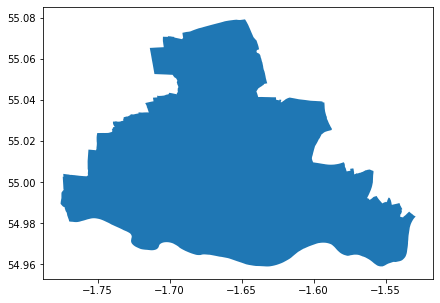

In [4]:
import geopandas as gpd
city_shape = gpd.read_file(os.path.join(conf.loc['DATA_PATH','val'],'newcastle.geojson'))

fig, ax = plt.subplots(figsize=(7,5))
city_shape.plot(ax=ax)

Get open sensors data of Newcastle upon Tyne from [Urban Observatory data portal](http://newcastle.urbanobservatory.ac.uk/) or from the API.

In [5]:
data = pd.read_csv('http://newcastle.urbanobservatory.ac.uk/api/v1.1/sensors/data/csv/?starttime=20180117100000&endtime=20180117120000&data_variable=Temperature')
data.head()

,Sensor Name,Variable,Units,Timestamp,Value,Flagged as Suspect Reading,Location (WKT),Ground Height Above Sea Level,Sensor Height Above Ground,Broker Name,Third Party,Sensor Centroid Longitude,Sensor Centroid Latitude
0,PER_EMOTE_2401,Temperature,Celsius,2018-01-17 10:00:03,2.9,False,POINT (-1.616125 54.981553),55.720001,2.0,Emote Air Quality Sensor,False,-1.616125,54.981553
1,PER_EMOTE_2407,Temperature,Celsius,2018-01-17 10:00:03,2.8,False,POINT (-1.617473 54.981342),53.160000,2.0,Emote Air Quality Sensor,False,-1.617473,54.981342
2,PER_EMOTE_2403,Temperature,Celsius,2018-01-17 10:00:03,2.6,False,POINT (-1.616489 54.982169),57.880001,2.0,Emote Air Quality Sensor,False,-1.616489,54.982169
3,PER_EMOTE_2408,Temperature,Celsius,2018-01-17 10:00:03,2.5,False,POINT (-1.617592 54.979084),57.509998,2.0,Emote Air Quality Sensor,False,-1.617592,54.979084
4,PER_EMOTE_2405,Temperature,Celsius,2018-01-17 10:00:03,2.1,False,POINT (-1.616803 54.980411),55.320000,2.0,Emote Air Quality Sensor,False,-1.616803,54.980411


Separate data in *samples* and *metadata*

In [6]:
# To resampĺe data by median values on regular intervals

samples = data[['Variable','Sensor Name','Timestamp','Value']].loc[data['Flagged as Suspect Reading']==False]
samples['Timestamp'] = pd.to_datetime(samples['Timestamp'])
samples = samples.set_index(['Variable','Sensor Name','Timestamp'])['Value']
level_values = samples.index.get_level_values
samples = (samples.groupby([level_values(i) for i in [0,1]]
                                  +[pd.Grouper(freq=conf.loc['SAMPLE_FREQ','val'], level=-1)]).median())

samples

Variable     Sensor Name                  Timestamp          
Temperature  PER_AIRMON_MESH1756150       2018-01-17 10:00:00    3.20
                                          2018-01-17 11:00:00    3.55
             PER_AIRMON_MESH1758150       2018-01-17 10:00:00    1.00
                                          2018-01-17 11:00:00    1.00
             PER_AIRMON_MESH1759150       2018-01-17 10:00:00    3.30
                                                                 ... 
             PER_WUNDERGROUND_IWHALTON2   2018-01-17 11:00:00    1.80
             PER_WUNDERGROUND_IWHITLEY15  2018-01-17 10:00:00    3.35
                                          2018-01-17 11:00:00    3.50
             PER_WUNDERGROUND_IWHITLEY16  2018-01-17 10:00:00    3.70
                                          2018-01-17 11:00:00    3.50
Name: Value, Length: 342, dtype: float64

In [7]:
import shapely

metadata = data[['Sensor Name',  'Ground Height Above Sea Level', 'Broker Name', 'Sensor Centroid Longitude', 'Sensor Centroid Latitude']]
metadata = metadata.set_index('Sensor Name').drop_duplicates()

# Transform into a GeoDataFrame
metadata['geometry'] = metadata.apply(lambda x: shapely.geometry.Point([(x['Sensor Centroid Longitude']), x['Sensor Centroid Latitude']]), axis=1)
metadata = gpd.GeoDataFrame(metadata, geometry=metadata['geometry'], crs={'init':'epsg:4326'})

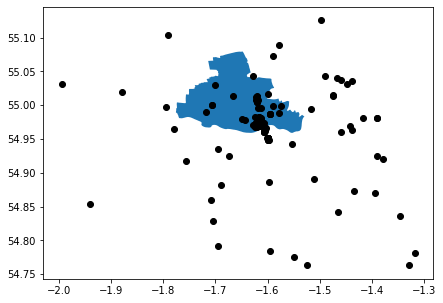

In [8]:
fig, ax = plt.subplots(figsize=(7,5))
city_shape.plot(ax=ax)
metadata.plot(ax=ax, color='black')

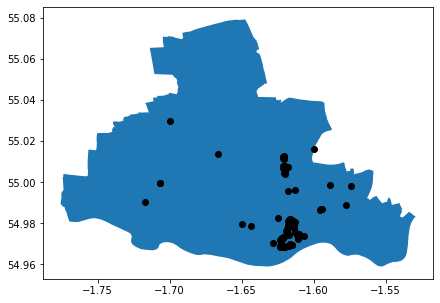

In [22]:
# To get sensors only within city_shape
metadata = gpd.sjoin(metadata, city_shape, op='within')[metadata.columns]

idx = pd.IndexSlice
samples = samples.loc[idx[:,metadata.index,:]]

fig, ax = plt.subplots(figsize=(7,5))
city_shape.plot(ax=ax)
metadata.plot(ax=ax, color='black')

Set the regions where predictions have be made. We call this set of regions as "grid"

In [46]:
bbox = {'north':city_shape.bounds.max().values[3],
        'east':city_shape.bounds.max().values[2],
        'south':city_shape.bounds.min().values[1],
        'west':city_shape.bounds.min().values[0]}

grid = geohunter.features.Grid(resolution=0.5).fit(city_shape).data

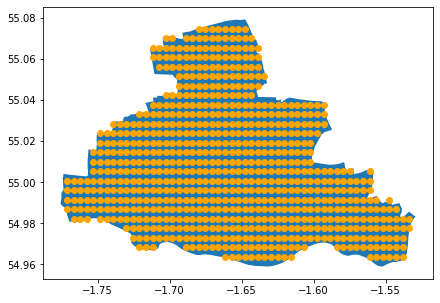

In [12]:
fig, ax = plt.subplots(figsize=(7,5))
city_shape.plot(ax=ax)
grid.plot(ax=ax, color='orange')

In [23]:
class Data(object):
    def __init__(self, samples, metadata, grid):
        self.samples = samples
        self.metadata = metadata
        self.metadata['lon'] = self.metadata.geometry.x
        self.metadata['lat'] = self.metadata.geometry.y
        self.grid = grid
        
data = Data(samples, metadata, grid)

Variable     Sensor Name                  Timestamp          
Temperature  PER_AIRMON_MESH1756150       2018-01-17 10:00:00    3.20
                                          2018-01-17 11:00:00    3.55
             PER_AIRMON_MESH1758150       2018-01-17 10:00:00    1.00
                                          2018-01-17 11:00:00    1.00
             PER_AIRMON_MESH1759150       2018-01-17 10:00:00    3.30
                                                                 ... 
             PER_WUNDERGROUND_INEWBURN2   2018-01-17 11:00:00    2.45
             PER_WUNDERGROUND_INEWBURN3   2018-01-17 10:00:00    2.10
                                          2018-01-17 11:00:00    2.10
             PER_WUNDERGROUND_INEWCAST49  2018-01-17 10:00:00    1.90
                                          2018-01-17 11:00:00    2.30
Name: Value, Length: 202, dtype: float64

# Feature Engineering

_____

In order to predict spatial variables, one have to translate samples into explanatory variables, also called features. Each spatial variable must be analysed separately and described in terms of spatial features.

One of the ways sensingbee extracts features is from Inverse Distance Weighting (IDW) estimations.

For now, let's extract primary features (Temperature features to predict Temperature, for instance). One can extract IDW from all places in grid, as below.

In [48]:
method = sensingbee.feature_engineering.inverse_distance_weighting

idx = pd.IndexSlice

params = {'p': 2, 'threshold': 10/110}
y = samples.loc['Temperature']
if False:
    X = pd.DataFrame(index=pd.MultiIndex.from_product([grid.index, samples.index.get_level_values('Timestamp')], names=['Sensor Name', 'Timestamp']))
    X = X.loc[~X.index.duplicated(keep='first')]
else:
    X = pd.DataFrame(index=y.index)
for var in samples.index.get_level_values('Variable').unique():
    for time in samples.index.get_level_values('Timestamp').unique():
        v_samples = samples.loc[idx[var, :, time]].reset_index()
        v_sensors = metadata.loc[v_samples['Sensor Name']]
        v_sensors = v_sensors.dropna()
        mask = y.loc[idx[:, time],:]
        if grid is not None:
            _ = grid.apply(lambda x: method(x,
                            v_sensors, v_samples.set_index('Sensor Name'), **params), axis=1)
            _.index = X.loc[idx[:, time],:].index
            X.loc[idx[:, time],var] = _.values
        else:
            _ = y.loc[idx[:, time],:].reset_index()['Sensor Name']\
                    .apply(lambda x: method(metadata.loc[x],
                            v_sensors, v_samples.set_index('Sensor Name'), **params))
            _.index = y.loc[idx[:, time],:].index
            X.loc[idx[:, time],var] = _.values

ValueError: Length mismatch: Expected axis has 758 elements, new values have 98 elements

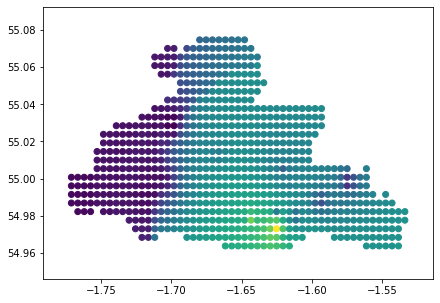

In [45]:
fig, ax = plt.subplots(figsize=(7,5))

t = '2018-01-17 10:00:00'
x = X.loc[idx[:,t],:].join(grid, on='Sensor Name')
gpd.GeoDataFrame(x).plot(column='Temperature', ax=ax)

In [29]:
distance_threshold = 10/69 # limit of 10 miles

X_idw, y = sensingbee.feature_engineering.Features(variable='Temperature',
    method='idw', p=2, threshold=distance_threshold).transform(samples, metadata)

ValueError: cannot set using a multi-index selection indexer with a different length than the value